In [1]:
# import das bibliotecas
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import collections
import os
from os.path import isfile, isdir, join
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars file:///home/jovyan/jdbc/postgresql-42.2.17.jar pyspark-shell'

In [3]:
db_url = "jdbc:postgresql://postgres:5432/dbinovacnj"
db_name = "dbinovacnj"
db_user = "inovacnj"
db_pass = "inovacnj@admin"
db_driver = "org.postgresql.Driver"

In [4]:
# inicialização do spark
conf = SparkConf() \
        .setMaster("local[2]") \
        .setAppName("PM-GerarModelos") \
        .set("spark.executor.memory", "2g") \
        .set("spark.driver.memory", "2g") \
        .set("spark.driver.maxResultSize", "1g") \
        .set("spark.sql.shuffle.partitions" , "800") \
        .set("spark.sql.execution.arrow.pyspark.enabled" , "false") \

spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .getOrCreate()

sc = spark.sparkContext

In [5]:
def gerar_modelo_pm_from_dbquery(query):
      
    df_logeventos = spark.read.format("jdbc") \
        .option("url", db_url).option("user", db_user).option("password", db_pass).option("driver", db_driver) \
        .option("query", query) \
        .load()
    
    df_logeventos_pd = df_logeventos.toPandas()
    dataframe = pm4py.format_dataframe(df_logeventos_pd, case_id='npu', activity_key='fase', timestamp_key='mov_dtmov')
    eventLog = pm4py.convert_to_event_log(dataframe)

    parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
    dfg = dfg_discovery.apply(eventLog, variant=dfg_discovery.Variants.PERFORMANCE)
    gviz = dfg_visualization.apply(dfg, log=eventLog, variant=dfg_visualization.Variants.PERFORMANCE, parameters=parameters)
    
    return gviz

In [6]:
def gerar_modelo_pm_from_params(codtribunal, grau, natureza, codclasse):
    print("gerando modelo com params: codtribunal: " + str(codtribunal) + 
          ", grau: " + str(grau) + 
          ", natureza: " + str(natureza) + 
          ", codclasse: " + str(codclasse))
    query = "SELECT npu, fase, mov_dtmov "
    query+= "FROM inovacnj.fat_movimentos_te "
    query+= "WHERE (1=1) "
    if codtribunal != None :
        query+= "AND codtribunal = '" + codtribunal + "' "
    if grau != None :
        query+= "AND grau = '" + grau + "' "
    if natureza != None :
        query+= "AND natureza = '" + natureza + "' "
    if codclasse != None :
        query+= "AND codclasse = " + str(codclasse) + " "
        
    query+= "ORDER BY mov_dtmov ASC "
    
    return gerar_modelo_pm_from_dbquery(query)

gerando modelo com params: codtribunal: TJPE, grau: G1, natureza: CRIMINAL, codclasse: None


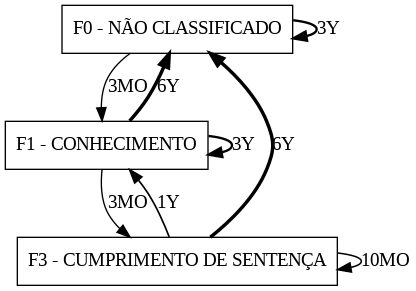

In [8]:
gviz = gerar_modelo_pm_from_params('TJPE', 'G1', 'CRIMINAL', None)
dfg_visualization.view(gviz)

In [11]:
import random
import string

def get_random_string(length):
    # Random string with the combination of lower and upper case
    letters = string.ascii_letters
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [12]:
path = "./output/" + get_random_string(8) + ".png"   
dfg_visualization.save(gviz, path)

Random string is: tzKJnPjH


In [ ]:
from flask import Flask
from flask import request
from flask import send_file


app = Flask(__name__)

@app.route('/gerar-modelo-pm')
def gerarModeloPm ():
    codtribunal = request.args.get('codtribunal')
    grau = request.args.get('grau')
    natureza = request.args.get('natureza')
    codclasse = request.args.get('codclasse')
    
    gviz = gerar_modelo_pm_from_params(codtribunal, grau, natureza, codclasse)
    
    path = "./output/pm_tmp_" + get_random_string(8) + ".png"
    
    dfg_visualization.save(gviz, path)
    
    return send_file(path, as_attachment=True)

app.run(host='0.0.0.0', port='8080')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8080/ (Press CTRL+C to quit)


gerando modelo com params: codtribunal: TJPE, grau: G1, natureza: CRIMINAL, codclasse: None


INFO:werkzeug:179.124.139.162 - - [19/Oct/2020 10:45:39] "GET /gerar-modelo-pm?codtribunal=TJPE&grau=G1&natureza=CRIMINAL HTTP/1.1" 200 -


Random string is: YhvoPcFc
gerando modelo com params: codtribunal: TJPE, grau: G1, natureza: CIVEL, codclasse: None


INFO:werkzeug:179.124.139.162 - - [19/Oct/2020 10:46:05] "GET /gerar-modelo-pm?codtribunal=TJPE&grau=G1&natureza=CIVEL HTTP/1.1" 200 -


Random string is: yXzmopGC
gerando modelo com params: codtribunal: TJPE, grau: G1, natureza: CRIMINAL, codclasse: 278


INFO:werkzeug:179.124.139.162 - - [19/Oct/2020 10:49:06] "GET /gerar-modelo-pm?codtribunal=TJPE&grau=G1&natureza=CRIMINAL&codclasse=278 HTTP/1.1" 200 -


Random string is: tQmdZYJM
